# Data Cleaning

This is a project aimed at helping lawyers doing cross-jurisdictional research by helping them quickly match a legislation provision of interest to its equivalent in another jurisdiction using vector similarity. 

This notebook is for data cleaning specific to the example data used for the first version of this project, specifically,
- Singapore Copyright Act & UK Copyright, Designs and Patents Act (CDPA)
- Singapore and UK Trade Marks Acts
- Singapore Personal Data Protection Act and European Union (EU) General Data Protection Regulation (GDPR)

For the first version of this project, everything is kept at section level granularity, and only one legislation per jurisdiction is matched to another's at a time.

Unfortunately, **the raw legislation data will not be uploaded to the repository** to stay clear of permission issues. The scripts to parse the html will also not be uploaded for similar reasons.

The cleaning in this notebook is done based on the particular quirks of the output of the parsed legislation html, and thus will likely not be entirely relevant for those using their own data. Users who wish to try out on their own gathered data should just use thie notebook as reference to prepare their data in the required format for use in the the subsequent notebooks.

**Refer to subsequent notebooks to read more about motivations for the project, word embedding methods and analysis.**

## Imports and Loading Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

## Data Formatting

### Specify ID Column Name

When we prepare the dataframes, we will have a column that uniquely identifies the entry. 

Given the small scope of this project where each dataset will only contain one legislation from each jurisdiction, the id_col will be named 'sec' for convenience, so that the section number data can eventually be dropped and just referenced based on the id.

Likewise, the entry will be identified just based on the jurisdiction + provision number. For example, SG Trade Mark Act section 5 will simply have id 'sg_5', and UK Trade Mark Act section 10 will have id 'uk_10'.

The unique identifier will be used for the matching later, and the format is important when specifying answer keys for the evaluation scripts to run on.

For users wishing to expand the scope of this application, the `id_col` can be named to something more appropriate than 'sec', and the format for creating id numbers can be more sophisticated to account for multiple legislation per jurisdiction, or different provision granularity like divisions or subsections.

In [2]:
id_col = 'sec'

### Output Format

At the end of notebook, the output data should be in the following format, with the legislation data from the two jurisdictions merged with the first jurisdictions data all above the second's.

For those preparing and cleaning their own data without this notebook, this is the format to take note of to use the data with subsequent notebook's scripts.

The outputs below demo based on data for the SG Copyright Act and UK CDPA, but do note as mentioned, the data files containing legislation content will not be in the repo.

In [3]:
required_output_cols = [id_col, 'title', 'url', 'cleaned']

In [4]:
# path name to save merged file to
save_merged_path = '../data/clean/copyright/sg_uk_copyright_test.csv'

<br>

## Cleaning and Preparing SG and UK Data

Jurisdiction A will be the input jurisdiction, for the purposes of v1 of this project, it will always be Singapore.

Jurisdiction B will be the output jurisdiction, and will be the UK for the Copyright and Trade Mark legislation, and the EU for the Data Protection legislation.

In [5]:
juris_A = 'sg'
juris_B = 'uk'

The data to be loaded already contains columns for legislation section no., title and content. 

In [6]:
# example for SG and UK trade mark legislation; raw data will not be uploaded to git repo
juris_A_filepath = '../data/raw/sg_copyright_act_data.csv'
juris_B_filepath = '../data/raw/uk_cdpa_data.csv'

In [7]:
df_A = pd.read_csv(juris_A_filepath)
df_B = pd.read_csv(juris_B_filepath)

It would be convenient to have the urls prepared, but there are functions below to generate the urls if not grabbed at the html parsing stage. These urls are not crucial for getting the legislation matching to work, but are convenient to have downstream to facilitate easier consumption of the matched legislation.

To prepare the base_url, get any example of the legislation, take notice where the provision number sits in the URL, and replace the provision number with a token like <SECNO> for easier replacement later. See below base_url examples.

In [8]:
# example for SG and UK trade mark legislation
juris_A_base_url = 'sso.agc.gov.sg/Act/TMA1998#pr<SECNO>-'
juris_B_base_url = 'www.legislation.gov.uk/ukpga/1994/26/section/<SECNO>'

In [9]:
def make_url(section_no, base_url, sec_token='<SECNO>'):
    return base_url.replace(sec_token, section_no)

### Clean SG Legislation Data

Assuming `df_A` is Singapore Legislation.

Create a new field of combined title and content so that we can embed the combined information later.

In [10]:
df_A['cleaned'] = df_A['title'] + ' ' + df_A['content']

Clean out numbers, as a large amount of them are not helpful information when matching meaning between different jurisdictions.

In [11]:
df_A['cleaned'] = df_A['cleaned'].map(lambda x: re.sub(r'\d{1,4}', '', x).replace('()','').strip())

Make urls if necessary.

In [12]:
df_A['url'] = \
df_A['section'].map(lambda x: make_url(x, base_url=juris_A_base_url))

Create id column.

In [13]:
df_A[id_col] = juris_A + '_' + df_A['section']

Consolidate function for cleaning SG data.

In [14]:
def clean_sg(df, juris='sg', base_url=None):
    df['cleaned'] = df['title'] + ' ' + df['content']
    df['cleaned'] = df['cleaned'].map(lambda x: re.sub(r'\d{1,4}', '', x).replace('()','').strip())
    df[id_col] = juris + '_' + df['section']
    
    # specify base_url in function arguments if need to create url
    if base_url:
        df['url'] = \
        df['section'].map(lambda x: make_url(x, base_url=base_url))
    
    return df

### Clean UK Legislation Data
Assuming `df_B` is UK Legislation.

The following data cleaning is particular to the way the UK legislation HTML was parsed. There were pecularities such as stray lettering throughout the content.

Improving the html parsing might result in some of the cleaning steps being redundant.

Note that we do not need to merge the title and content as we did for SG, as the way the html was parsed already resulted in the section title appearing in the main content.

In [15]:
df_B = df_B.dropna()

In [16]:
df_B['cleaned'] = df_B['content'].map(lambda x: x.replace('U.K.', ' '))
df_B['cleaned'] =  df_B['cleaned'].map(lambda x: re.sub(r'F\d{1,3}', ' ', x).replace('[','').strip())
df_B['cleaned'] =  df_B['cleaned'].map(lambda x: re.sub(r'X\d{1,3}', ' ', x).replace('[','').strip())
df_B['cleaned'] = df_B['cleaned'].map(lambda x: re.sub(r'\d{1,4}[A-Z]{0,2}\s', '', x).strip())
df_B['cleaned'] =  df_B['cleaned'].map(lambda x: re.sub(r'\d{1,4}', '', x).replace('()','').strip())

Clean alphabets appearing at start of content that comes from section numbering.

In [17]:
for _, row in df_B.iterrows():
    if re.search(r'[A-Z]', row['section']) is not None:
        sec_alpha = re.sub(r'\d{1,3}', '', row['section'])
        row['cleaned'] = re.sub(sec_alpha, '', row['cleaned'], count=1)

Some UK legislation have stray 'n1's appearing where 'A' should appear in the section numbers. Fix this.

In [18]:
df_B['section'] = df_B['section'].map(lambda x: x.replace('n1', 'A'))

Unfortunately, there are some 'valid' UK legislation sections where the content should be empty but the web content contains some explanatory text and a lot of '....', these seem to be some problematic legislation in the process of being worked out due to Brexit.

These rows have to manually inspected. A more elegant way is to dig deeper to account for all the content patterns for these situations, but for the purposes of this version, we will have to quickly inspect and remove such provisions.

In [ ]:
# df_B[['section','cleaned']]

In [19]:
# example rows (actual df rows, not sec numbers) 
# for cdpa
drop_rows = [7, 10, 19, 58, 59, 60, 61, 71, 113, 178, 179, 381, 384, 400, 401, 402, 433]

# for tm act
# drop_rows = [71]

In [20]:
df_B = df_B.drop(index=drop_rows)

Make urls if necessary.

In [21]:
df_B['url'] = \
df_B['section'].map(lambda x: make_url(x, base_url=juris_B_base_url))

Create id column.

In [22]:
df_B[id_col] = juris_B + '_' + df_B['section']

Consolidate function for cleaning UK data.

In [23]:
def clean_uk(df, juris='uk', base_url=None, drop_rows=None):
    df = df.dropna()
    df['cleaned'] = df['content'].map(lambda x: x.replace('U.K.', ' '))
    df['cleaned'] =  df['cleaned'].map(lambda x: re.sub(r'F\d{1,3}', ' ', x).replace('[','').strip())
    df['cleaned'] =  df['cleaned'].map(lambda x: re.sub(r'X\d{1,3}', ' ', x).replace('[','').strip())
    df['cleaned'] = df['cleaned'].map(lambda x: re.sub(r'\d{1,4}[A-Z]{0,2}\s', '', x).strip())
    df['cleaned'] =  df['cleaned'].map(lambda x: re.sub(r'\d{1,4}', '', x).replace('()','').strip())
    
    for _, row in df.iterrows():
        if re.search(r'[A-Z]', row['section']) is not None:
            sec_alpha = re.sub(r'\d{1,3}', '', row['section'])
            row['cleaned'] = re.sub(sec_alpha, '', row['cleaned'], count=1)

    df['section'] = df['section'].map(lambda x: x.replace('n1', 'A'))
    df[id_col] = juris + '_' + df['section']
    
    # drop_rows should take a list of the indices to be dropped
    if drop_rows:
        df = df.drop(index=drop_rows)
    
    # specify base_url in function arguments if need to create url
    if base_url:
        df['url'] = \
        df['section'].map(lambda x: make_url(x, base_url=base_url))
    
    return df

### Merge SG and UK Data

In [24]:
merged = pd.concat([df_A[required_output_cols], df_B[required_output_cols]])

In [ ]:
## for additional clarity, same as
## merged = pd.concat([df_A[[id_col, 'title', 'url', 'cleaned']], df_B[[id_col, 'title', 'url', 'cleaned']]])

In [25]:
merged.shape

(780, 4)

Save data.

In [ ]:
# save_merged_path = ''

In [26]:
merged.to_csv(save_merged_path, index=False)

<br>

## Get Sense of Word Count

Word count will be important to get an estimate of for the later embedding steps. For example, BERT only accepts up to 512 tokens at a time, so we need to be aware of how much of the data might be affected through truncating after 512 tokens if we choose to.

Text(0, 0.5, 'Documents')

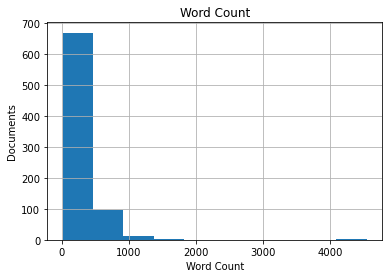

In [27]:
merged['cleaned'].map(lambda x: len(x.split(' '))).hist()
plt.title('Word Count')
plt.xlabel('Word Count')
plt.ylabel('Documents')

<br>

## Cleaning and Preparing SG and EU Data
Data Protection Laws

Jurisdiction A is Singapore.

Jurisdiction B is the EU for the Data Protection legislation.

In [ ]:
juris_A = 'sg'
juris_B = 'eu'

In [ ]:
# example for SG and EU data protection legislation; raw data will not be uploaded to git repo
juris_A_filepath = '../data/raw/sg_pdpa_data.csv'
juris_B_filepath = '../data/raw/gdpr_data.csv'

In [ ]:
df_A = pd.read_csv(juris_A_filepath)
df_B = pd.read_csv(juris_B_filepath)

In [ ]:
# example for SG and EU data protection laws
juris_A_base_url = 'sso.agc.gov.sg/Act/PDPA2012#pr<SECNO>-'
juris_B_base_url = 'gdpr.eu/article-<SECNO>'

### Clean SG Legislation Data

Use the clean_sg function defined above.

In [ ]:
df_A = clean_sg(df_A, base_url=juris_A_base_url)

### Clean EU GDPR Data

`df_B` is now EU GDPR data.

The format is different from UK legislation and requires separate cleaning.

Like for SG, create a new field of combined title and content so that we can embed the combined information later.

Clean numbers (with dots after, dots included, and in general), brackets, and slashes. 

In [ ]:
df_B['cleaned'] df_B['title'] + ' ' + df_B['content']
df_B['cleaned'] = df_B['cleaned'].map(lambda x: re.sub(r'\d{1,4}\.', '', x).strip())
df_B['cleaned'] = df_B['cleaned'].map(lambda x: re.sub(r'\d{1,4}', '', x).replace('()','').replace('/', '').strip())

Create id column. Ensure the word 'Article ' is removed, just preserving the number. We will treat GDPR articles as sections for the purpose of this exercise.

In [ ]:
df_B[id_col] = juris_B + '_' + df_B['section'].map(lambda x: x.replace('Article ', ''))

In [ ]:
df_B['url'] = \
df_B['section'].map(lambda x: make_url(x.replace('Article ',''), base_url=juris_B_base_url))

Consolidate function for cleaning EU data.

In [ ]:
def clean_eu(df, juris='eu', base_url=None):
    df['cleaned'] = df['title'] + ' ' + df_B['content']
    df['cleaned'] = df['cleaned'].map(lambda x: re.sub(r'\d{1,4}\.', '', x).strip())
    df['cleaned'] = df['cleaned'].map(lambda x: re.sub(r'\d{1,4}', '', x).replace('()','').replace('/', '').strip())
    df[id_col] = juris + '_' + df['section'].map(lambda x: x.replace('Article ', ''))
    # specify base_url in function arguments if need to create url
    if base_url:
        df['url'] = \
        df['section'].map(lambda x: make_url(x.replace('Article ',''), base_url=juris_B_base_url))
    
    return df

### Merge SG and EU Data

In [ ]:
merged = pd.concat([df_A[required_output_cols], df_B[required_output_cols]])

In [ ]:
merged.shape

Save data.

In [ ]:
save_merged_path = ''

In [ ]:
merged.to_csv(save_merged_path, index=False)

<br>